# Neural & Behavioral Modeling - Week 6 (Exercises)
by 劉昱維 (r08227111@ntu.edu.tw)

In [1]:
%config IPCompleter.greedy=True 
%matplotlib inline
from numpy import *
from matplotlib.pyplot import *
from IPython.display import *

## 1 Drifit Diffusion Model (5 points)

Use whatever analytical methods to check if Tren's super EZ implementation(s) of the drift diffusion model produce exGaussian data, especially the exponential long tail. Remember to play around with different model parameters to see how they affect simulation results.

Hints:

[1] For parameter estimation of the ex-Gaussian distribution, you can use scipy.stats.exponnorm.fit().

[2a] You can compare two distributions by Q-Q plots or the Kolmogorov–Smirnov test

[2b] Alternatively, you can compare AIC/BIC to answer whether Exponential, Gaussian, or ex-Gaussian best fits Tren's data.

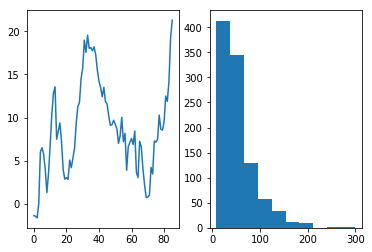

In [5]:
# Tren's implementation
from numpy import *
mu,sigma=0.2,2                              # Diffusion type1
p=0.4                                       # Diffusion type2
Yend=20                                     # Threshold for response
Ntrial=1000

RTs=zeros(Ntrial)
for i in range(Ntrial):
    Y=0                                     # initial drift position
    Ys=[]                                   # drift history
    RT=0                                    # Reset watch
    while(Y < Yend):
        dY = mu + random.normal(mu,sigma);  # type1
        #dY=float((random.rand(1)-p)>0);    # type2
        Y = Y + dY
        Ys.append(Y);                       # Diffusion history in each trial
        RT = RT + 1                         # clock is running
    RTs[i]=RT;
subplot(1,2,1);plot(Ys)                     # plot only the last trial to see the diffusion process
subplot(1,2,2);hist(RTs);

### 1. 檢查RTs分配是否符合Ex-Gaussian Distribution、Exponential Distribution或是 Normal distribution。
1. 繪製 Tren's super EZ histogram 疊上各分配的pdf曲線
2. 繪製 Q-Q Plot
3. 統計檢定：Kolmogorov–Smirnov test

#### **Reference:** 
1. Model Fit: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.exponnorm.html
2. Q-Q Plot: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html
3. Kolmogorov–Smirnov test: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html
4. 套件給回的參數與實際上運算的lmbd不匹配: Credit to 林子堯

In [6]:
### Write your analysis or codes here
from scipy.stats import exponnorm, expon, norm,probplot, kstest
from scipy.special import erfc

class SuperEZ(object):
    def __init__(self):
        self.Yend=20                                  # Threshold for response
        self.Ntrial=1000
        self.distr = None
        self.fitparams = None
        self.distriData = None
        self.map = {
            'ExGaussian':'exponnorm',
            'Exponential':'expon',
            'Normal':'norm',
        }
        self.islikelihood = False
        self.mu = 0.2                                 # Parameters: Diffusion type1                       
        self.sigma = 2 
        self.lmbd = 0.5
        
        self.RTs = zeros(self.Ntrial)                 # Step1: Init Tren's RTs data
        self.genTrenRTs()                             
        
        self.x = arange(0, self.RTs.max(), 0.05)       # Next, go to self.fit() 
                                            
                                                      
        
    def genTrenRTs(self):
        Y,RT = 0,0
        for i in range(self.Ntrial):
            Y = 0                                     # initial drift position
            RT = 0                                    # Reset watch
            while(Y < self.Yend):
                dY = self.mu + random.normal(self.mu,self.sigma); 
                Y = Y + dY
                RT += 1                               # clock is running
            self.RTs[i] = RT
        return
        
    def fit(self, distribute,islikelihood):
        '''
        Step2: Fit RTs data. 
        Step3: Got fit parameters - > self.fitparams
        Step4: Generate distribution data -> self.distriData
        '''
        self.distr = distribute
        self.islikelihood = islikelihood
        if self.distr == "ExGaussian":
            self.fitparams = exponnorm.fit(self.RTs)
            if self.islikelihood:
                self.distriData = self.pdf_ExGaussian(self.RTs, 
                                             self.fitparams[1],
                                             self.fitparams[2],
                                             1/(self.fitparams[0]*self.fitparams[2]))
            else:
                print("here!!!!!!!!!!!!!!!!!!!!!!!")
                self.distriData = self.pdf_ExGaussian(self.x, 
                                             self.fitparams[1],
                                             self.fitparams[2],
                                             1/(self.fitparams[0]*self.fitparams[2]))
        elif self.distr == "Exponential":
            self.fitparams = expon.fit(self.RTs)
            if self.islikelihood:
                self.distriData = self.pdf_Exponential(self.RTs, 
                                             self.fitparams[0],
                                             1/self.fitparams[1])
            else:
                self.distriData = self.pdf_Exponential(self.x, 
                                             self.fitparams[0],
                                             1/self.fitparams[1])
        elif self.distr == "Normal":
            self.fitparams = norm.fit(self.RTs)
            if self.islikelihood:
                self.distriData = self.pdf_Normal(self.RTs, 
                                             self.fitparams[0],
                                             self.fitparams[1])
            else:
                self.distriData = self.pdf_Normal(self.x, 
                                             self.fitparams[0],
                                             self.fitparams[1])
        else:
            return 
        
    def pdf_ExGaussian(self, x, mu, sigma, lmbd):
        exGauss_val = lmbd/2*exp(lmbd/2*(2*mu+lmbd*sigma**2-2*x))*erfc((mu+lmbd*sigma**2-x)/(sqrt(2)*sigma))
        return exGauss_val
    
    def pdf_Exponential(self,x, mu, lmbd):
        ex_val = lmbd*exp(-lmbd*(x-mu))
        return ex_val
    
    def pdf_Normal(self, x, mu, sigma):
        normal_val =  1/sqrt(2*pi*sigma**2)*exp(-((x-mu)/sigma)**2/2)
        return normal_val
    
    def plot(self):
        fig, axes = subplots(nrows=1, ncols=2, figsize=(12,6))
        
        # Histgram & Fit line
        axes[0].set_xlim([0, 300])
        axes[0].set_ylim([0, 0.025])
        axes[0].hist(self.RTs,bins=30, density=True, histtype='bar', ec='blue')
        axes[0].plot(self.x, self.distriData)
        axes[0].legend([self.distr,'Tren\'s RTs'])
        axes[0].set_title('{0} V.S Tren\'s EZ'.format(self.distr), fontsize=14)
        
        # Q-Q Plot
        res = probplot(self.RTs,sparams = self.fitparams, dist=self.map[self.distr], plot=axes[1])
        axes[1].set_ylim([0, 300])
        axes[1].set_title('Q-Q Plot', fontsize=14)
        axes[1].set_xlabel('{0} Distribution Theoretical Quantile'.format(self.distr) , fontsize=14)
        axes[1].set_ylabel('Tren\'s RTs Quantile', fontsize=14)
        return
    
    def getStaticResult(self, detail):
        s, p_value = kstest(self.RTs, cdf=self.map[self.distr], args=self.fitparams)
        if self.islikelihood:
            self.fit(self.distr,True)
        likelihood = sum(log(self.distriData))
        K = len(self.fitparams)
        N = len(self.RTs)
        self.AIC = -2*likelihood + 2*K
        self.BIC = -2*likelihood + log(N)*K
        if p_value >= 0.05:
            report = '''
                    <h1 align='left'>{0} 統計檢定報告</h1>
                    <h4 align='left'>虛無假設H0: RTs~{0}分配{1}</h4>
                    <h4 align='left'>對立假設H1: RTs!~{0}分配{1}</h4>
                    <h4 align='left'>結論:<I>p</I>-value:{2} > 0.05, 接受虛無假設。</h4>
                    <h4 align='left'>表示RTs確實來自{0}分配</h4>
                    '''.format(self.distr, around(self.fitparams,2),p_value)
        else:
            report = '''
                    <h1 align='left'>{0} 統計檢定報告</h1>
                    <h4 align='left'>虛無假設H0: RTs~{0}分配{1}</h4>
                    <h4 align='left'>對立假設H1: RTs!~{0}分配{1}</h4>
                    <h4 align='left'>結論:<I>p</I>-value:{2} < 0.05, 拒絕虛無假設。</h4>
                    <h4 align='left'>表示RTs與{0}分配有差異，並不屬於{0}分配</h4>
                    '''.format(self.distr, around(self.fitparams,2),p_value)
        if detail:
            display(HTML(report))
        return [self.distr, K, likelihood, self.AIC, self.BIC]

def main(distr):
    ez = SuperEZ()
    ez.fit(distr,False)        
    ez.getStaticResult(True)
    ez.plot()
    
if __name__ == '__main__':
    #main('ExGaussian')
    #main('Exponential')
    #main('Normal')
    pass

here!!!!!!!!!!!!!!!!!!!!!!!


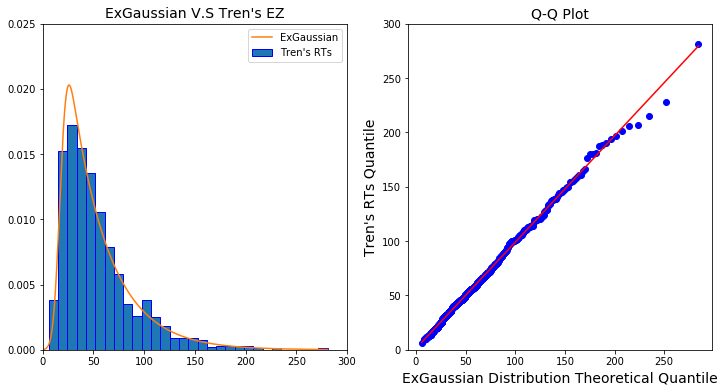

In [7]:
main('ExGaussian')

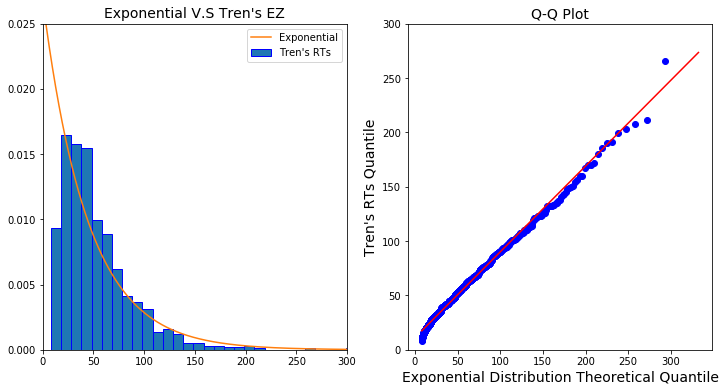

In [8]:
main('Exponential')

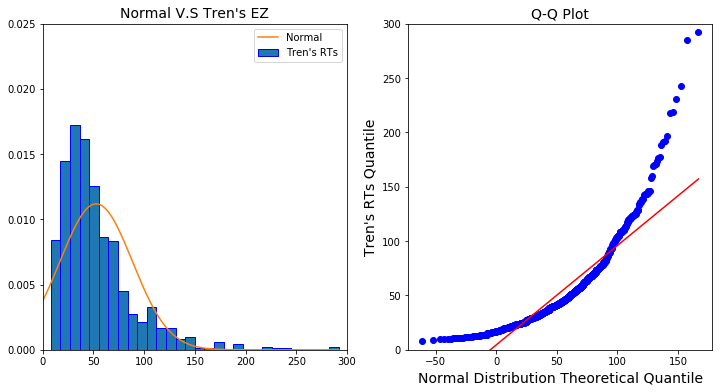

In [9]:
main('Normal')

### 2. 比較模型之間的AIC/BIC指標 

In [10]:
### Write your codes here
from pandas import DataFrame
ez = SuperEZ()
comparetable = []
for distr in ez.map:
    ez.fit(distr,True)
    comparetable.append(ez.getStaticResult(False))

df = DataFrame(comparetable,columns=['Distribution','K', 'Likelihood', 'AIC', 'BIC'])
display(HTML(df.to_html()))


report = '''
<h4>AIC最低的模型:{0}</h4>
<h4>BIC最低的模型:{1}</h4>
'''.format(str(df.loc[:,"Distribution"][df.loc[:,"AIC"][df.loc[:,"AIC"]==df.loc[:,"AIC"].min()].index][0]),
          str(df.loc[:,"Distribution"][df.loc[:,"BIC"][df.loc[:,"BIC"]==df.loc[:,"BIC"].min()].index][0]))
display(HTML(report))

,Distribution,K,Likelihood,AIC,BIC
0,ExGaussian,3,-4727.010127,9460.020255,9474.743520
1,Exponential,2,-4843.380073,9690.760145,9700.575656
2,Normal,2,-4985.918607,9975.837215,9985.652725
